In [ ]:
import numpy as np
import pandas as pd 
import hvplot as hv
import hvplot.pandas
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, mean_absolute_error, mean_squared_error

from src.util.model import eval_model, prep_data
seed = 42

In [88]:
dff0 = pd.DataFrame()

data_fp = "../../data/training_data"
for fn in os.listdir(data_fp):
    df = pd.read_csv(os.path.join(data_fp, fn))
    print(f"{fn} {df.shape}")
    if fn.split(".")[0][-1] == "1":
        continue
    else:
        dff0 = pd.concat([dff0, df])
print(dff0.shape)

snow_2020-2025_p160_fxx1.csv (35016, 68)
snow_2020-2025_p160_fxx0.csv (29184, 68)
snow_2020-2025_p159_fxx0.csv (29184, 68)
snow_2020-2025_p159_fxx1.csv (35016, 68)
(58368, 68)


In [89]:
# os.listdir("../../../data/FACFAC_Danger_rating_zone_elv.csv")
danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])
danger_levels = danger_levels.drop_duplicates()
danger_levels = danger_levels[danger_levels['lower'] > -1]

danger_levels = danger_levels[danger_levels['forecast_zone_id'] == "whitefish"]
danger_levels = danger_levels[['date','lower']]
print(danger_levels.shape)
print(danger_levels.head())


danger_levels['lower'].value_counts(normalize=True)


(1343, 2)
         date  lower
20 2020-10-19      0
21 2020-10-20      0
22 2020-10-21      0
23 2020-10-22      0
24 2020-10-23      0


lower
1    0.677587
2    0.217424
0    0.057334
3    0.046165
4    0.001489
Name: proportion, dtype: float64

In [90]:
X, y = prep_data(
    dff0, 
    danger_levels, 
    "lower", 
    replace_missing=True, 
    change_danger=True, 
    exclude_cols=['date','id','slope_azi', 'danger_level', 'altitude']) 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [105]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight="balanced",classes=y.unique(), y=y)
weights[2] *= 2
weights[1] *= 2
weight_dict = {}

for i in range(len(weights)):
    weight_dict[i] = weights[i]
    
print(weight_dict)

{0: np.float64(4.3603896103896105), 1: np.float64(2.2996575342465753), 2: np.float64(10.4921875), 3: np.float64(0.368956043956044)}


Train
Accuracy 0.64
MSE: 0.46914893617021275
RMSE: 0.6849444767061142
MAE: 0.39680851063829786
Test
Accuracy 0.58
MSE: 0.48635235732009924
RMSE: 0.697389673941405
MAE: 0.44168734491315137


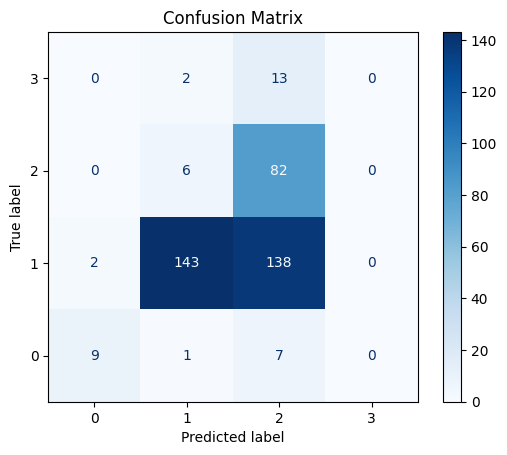

In [106]:
dtree = DecisionTreeClassifier(random_state=seed, max_depth=5,min_samples_leaf=5, class_weight=weight_dict)
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)

print("Train")
eval_model(y_train, dtree.predict(X_train))

print("Test")
eval_model(y_test, y_pred,plot=True)

In [17]:
y_train_proba = dtree.predict_proba(X_train)
y_train_pred = np.argmax(y_train_proba, axis=1)
train_acc = eval_model(y_train, y_train_pred)

y_train_proba = dtree.predict_proba(X_test)
y_train_pred = np.argmax(y_train_proba, axis=1)
train_acc = eval_model(y_test, y_train_pred)


Accuracy 0.69
MSE: 0.46880570409982175
RMSE: 0.6846938761956483
MAE: 0.36541889483065954
Accuracy 0.61
MSE: 0.6639004149377593
RMSE: 0.8148008437267105
MAE: 0.48132780082987553


In [18]:
feature_importances = pd.DataFrame(dtree.feature_importances_,index = X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=False)

print(feature_importances[feature_importances['importance'] > 0])

                importance
hoar_size         0.196610
Sclass2           0.146521
Qs                0.138307
Ql                0.102800
OLWR              0.087856
HN72_24           0.087679
dIntEnergySnow    0.085709
zSd               0.051755
HS_mod            0.040151
HN24              0.031253
RH                0.028564
TSS_mod           0.002793


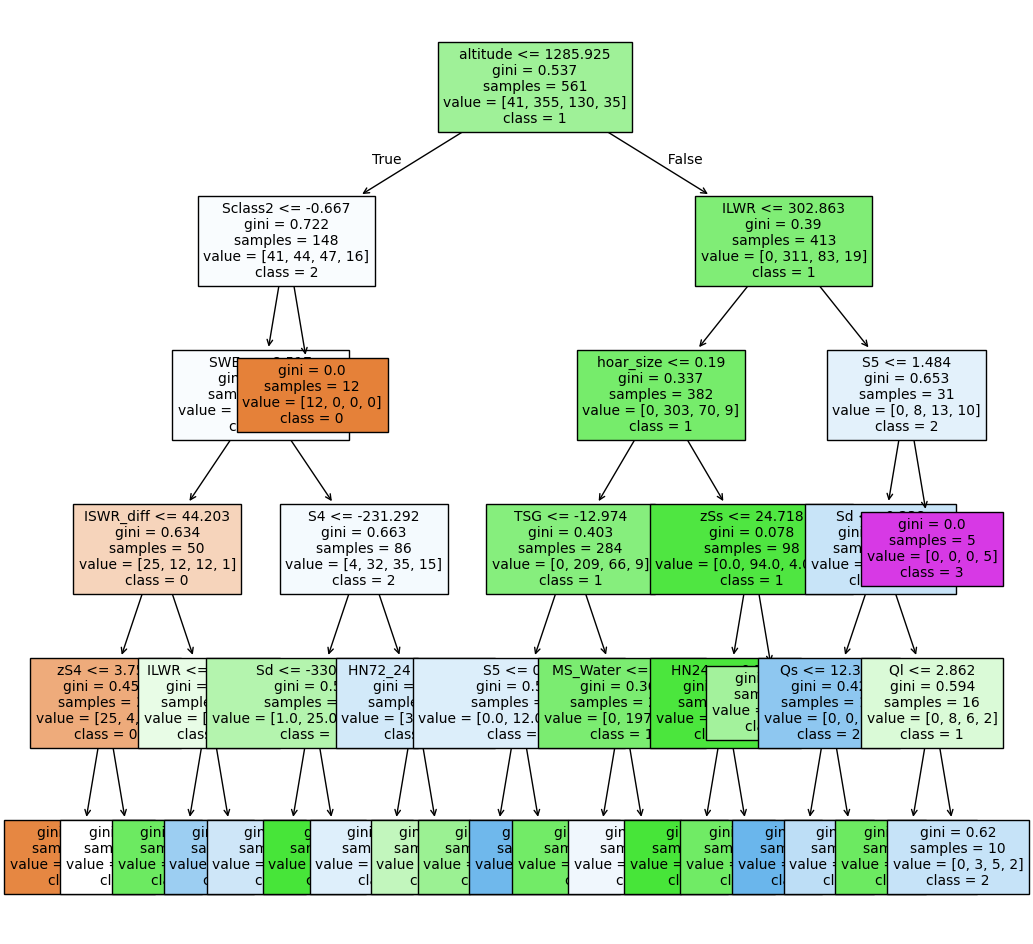

In [24]:
plt.figure(figsize=(12,12),dpi=100)
plot_tree(dtree, max_depth=5,fontsize=10,feature_names=X_test.columns, class_names=['0','1','2','3'], filled=True)
plt.show()